# Equity Risk Premium Analysis (Portfolio Project)


## 1. Introduction

In this project, we estimate and analyze the **Equity Risk Premium (ERP)** using historical U.S. market data.  
We replicate and extend academic-style estimation methods, evaluate performance across time,  
and explore how alternative optimization approaches affect portfolio outcomes.

In [ ]:
import pandas            as pd
import numpy             as np
import scipy             as scp
import matplotlib.pyplot as plt
import os as os
from datetime import date as dd
from scipy import stats
from scipy import optimize
import statsmodels.api as sm
# %matplotlib inline

## 2. Data Overview

We use a monthly multi-asset dataset containing U.S. equity, bond, and gold returns  
from January 1970 onward. The dataset integrates value-weighted market returns,  
Treasury yields, and commodity performance to study the **Equity Risk Premium (ERP)**.

| Variable | Description |
|-----------|--------------|
| `vwret` | Value-weighted market return (proxy for U.S. equity market performance) |
| `3m` | 3-month Treasury Bill return (proxy for risk-free rate) |
| `10y` | 10-year Treasury return (long-term bond benchmark) |
| `dp` | Dividend–price ratio (predictive variable for ERP) |
| `Gold` | Monthly gold return (alternative defensive asset) |

We focus on the **‘Data’** sheet of the workbook, which consolidates the primary  
macroeconomic and financial indicators required to estimate the ERP.


In [ ]:
os.getcwd()
df=pd.read_excel('us_equity_factors_1963_2025.xlsx', sheet_name='Data')
os.getcwd()

'/content'

In [ ]:
df.head()

,Date,vwret,mkt_index,dp,10y,10y_index,3m,3m_index,Gold
0,01/31/1970,-0.075398,100.000000,0.037207,0.028827,100.000000,0.007158,100.000000,0.000000
1,02/28/1970,0.059521,105.269348,0.035382,0.067886,106.788595,0.007986,100.798584,0.000857
2,03/31/1970,0.002806,105.422254,0.035368,-0.000269,106.759882,0.007078,101.512027,0.007964
3,04/30/1970,-0.088831,95.883322,0.038927,-0.050871,101.328913,0.005494,102.069753,0.015461
4,05/31/1970,-0.054689,90.037638,0.041498,-0.006522,100.668015,0.006237,102.706368,-0.011220


In [ ]:
# clean and reorganize the data
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

date = df["Date"]                     # monthly observation date

returns = df["vwret"]                 # value-weighted market return (equity market performance)
mkt_index = df["mkt_index"]           # synthetic market index level (base=100)
dp = df["dp"]                         # dividend–price ratio (valuation signal, not inflation)

rf10 = df["10y"]                      # long-term government bond return (10-year Treasury)
rf10_index = df["10y_index"]          # cumulative index level of 10-year Treasury bond

rfrate = df["3m"]                     # short-term risk-free rate (3-month Treasury Bill)
rfrate_index = df["3m_index"]         # cumulative index level of 3-month T-bill

gold = df["Gold"]                     # gold monthly return (alternative defensive asset)


### 3. Estimating the Historical Equity Risk Premium

In this section, we estimate the **average equity risk premium (ERP)**, the excess return on the market portfolio (value-weighted stock index) over the short-term
risk-free rate (3-month Treasury Bill).

We follow standard empirical asset pricing methodology:
1. Compute the monthly excess return: \( r_t^{excess} = r_t^{stock} - r_t^{rf} \)
2. Estimate the mean and its standard error by regressing \( r_t^{excess} \) on a constant.
3. Annualize the mean and construct a 95% confidence interval to assess whether the mean excess return is statistically different from zero。


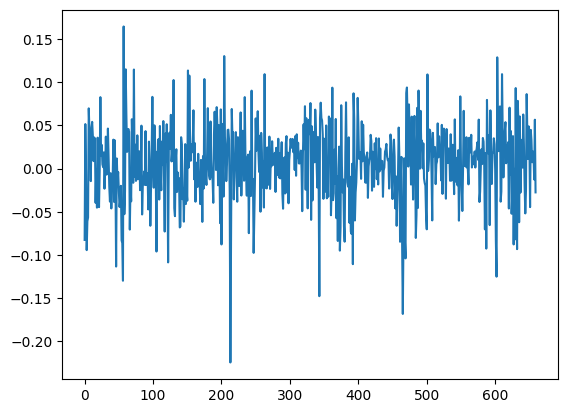

In [ ]:
erp = returns - rfrate         # excess return
plt.plot(erp)

In [ ]:
# OLS regression on a constant to get mean and standard error
X = np.ones(len(erp))                       # constant term only
ols = sm.OLS(erp, X).fit()

# extract monthly mean and standard error
erp_monthly_mean = ols.params['const']
erp_monthly_se   = ols.bse['const']

# annualize mean and standard error
erp_annual_mean = erp_monthly_mean * 12
erp_annual_se   = erp_monthly_se * 12

# construct 95% confidence interval
t_stat = ols.tvalues["const"]
p_value = ols.pvalues["const"]

lower = erp_annual_mean - 1.96 * erp_annual_se
upper = erp_annual_mean + 1.96 * erp_annual_se

ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 13 Oct 2025   Prob (F-statistic):                nan
Time:                        00:04:08   Log-Likelihood:                 1119.3
No. Observations:                 660   AIC:                            -2237.
Df Residuals:                     659   BIC:                            -2232.
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0058      0.002      3.347      0.001       0.002       0.009
==============================================================================
Omnibus:                       47.829   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               95.480
Skew:                          -0.451   Prob(JB):                     1.85e-21
Kurtosis:                       4.631   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
erp_summary = pd.DataFrame({
    "Metric": [
        "ERP Mean (Annualized)",
        "Std. Error",
        "t-statistic",
        "p-value",
        "95% CI Lower",
        "95% CI Upper"
    ],
    "Value": [
        erp_annual_mean,
        erp_annual_se,
        t_stat,
        p_value,
        lower,
        upper
    ]
})

# Format for readability
erp_summary["Value"] = [
    f"{v:.2%}" if i in [0, 1, 4, 5] else
    f"{v:.3f}" if i == 2 else
    f"{v:.3f}" for i, v in enumerate(erp_summary["Value"])
]

display(erp_summary)

,Metric,Value
0,ERP Mean (Annualized),6.94%
1,Std. Error,2.07%
2,t-statistic,3.347
3,p-value,0.001
4,95% CI Lower,2.88%
5,95% CI Upper,11.01%


### ERP Estimation Summary

The estimated **annualized equity risk premium (ERP)** is **6.9%** with a **standard error of 2.1%**.  
The 95% confidence interval of **[2.9%, 11.0%]** indicates that the estimate is **statistically significant**  
(_t = 3.35, p = 0.001_), providing strong evidence that equities have historically outperformed Treasury bills.

From an **economic perspective**, the magnitude of the premium is consistent with long-term findings in the  
U.S. equity market literature (typically 5–8% per year). However, the **confidence band remains wide** (roughly eight percentage points) reflecting substantial **volatility in equity returns** and the inherent  
uncertainty of sample-based estimates, even over multi-decade periods.


## 4. Stability of the Equity Risk Premium Over Time

We evaluate how stable the historical **equity risk premium (ERP)** has been across time.

To assess temporal variation, we compute a **10-year (120-month) rolling average** of the monthly excess returns. This smooths out short-term fluctuations and highlights long-term trends in the realized risk premium.

A stable ERP would suggest that the compensation investors receive for bearing equity risk
is consistent through time. Large swings, however, indicate that the observed premium
is highly dependent on the specific sample period. This is an important consideration for long-horizon investors and model calibration.


In [ ]:
window = 120  # 10 years

# rolling 10-year mean in monthly units
ma_erp_monthly = erp.rolling(window=window).mean()

# rolling 10-year mean in annualized units
ma_erp_annualized = ma_erp_monthly * 12

# Basic descriptive statistics
mean_val = ma_erp_monthly.mean()
std_val = ma_erp_monthly.std()
cv_val = std_val / abs(mean_val)
range_val = ma_erp_monthly.max() - ma_erp_monthly.min()
autocorr_val = ma_erp_monthly.autocorr(lag=1)

vol_summary = pd.DataFrame({
    "Metric": [
        "Mean (Monthly)",
        "Std. Deviation",
        "Coeff. of Variation (CV)",
        "Range (Max - Min)",
        "Lag-1 Autocorrelation"
    ],
    "Value": [
        mean_val, std_val, cv_val, range_val, autocorr_val
    ]
})

vol_summary["Value"] = [
    f"{v:.4f}" if i < 4 else f"{v:.3f}"
    for i, v in enumerate(vol_summary["Value"])
]

display(vol_summary)

,Metric,Value
0,Mean (Monthly),0.0059
1,Std. Deviation,0.0036
2,Coeff. of Variation (CV),0.6166
3,Range (Max - Min),0.0176
4,Lag-1 Autocorrelation,0.990


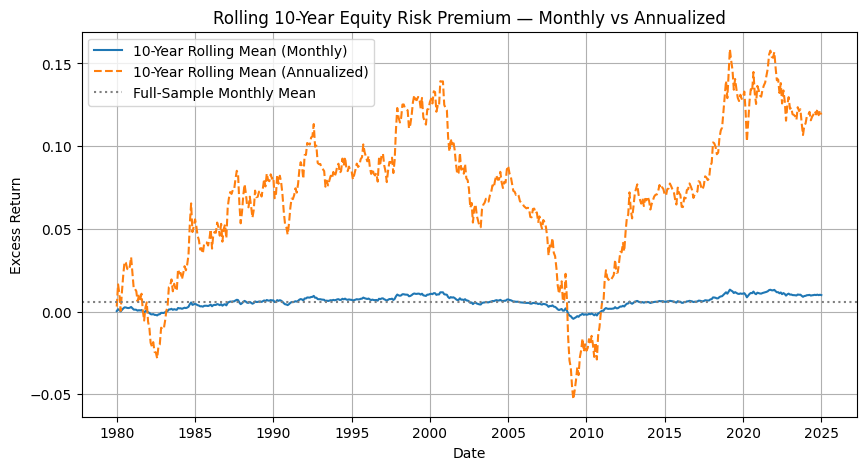

In [ ]:
# visualise the moving averages
plt.figure(figsize=(10,5))
plt.plot(df["Date"], ma_erp_monthly, label="10-Year Rolling Mean (Monthly)")
plt.plot(df["Date"], ma_erp_annualized, label="10-Year Rolling Mean (Annualized)", linestyle="--")
plt.axhline(erp_monthly_mean, color='gray', linestyle=':', label="Full-Sample Monthly Mean")
plt.title("Rolling 10-Year Equity Risk Premium — Monthly vs Annualized")
plt.ylabel("Excess Return")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.show()

### ERP Volatility Summary

The quantitative diagnostics show that the **equity risk premium (ERP)** is **highly time-varying**.

- The mean monthly ERP of **0.59%** contrasts with a standard deviation of **0.36%**,  producing a **coefficient of variation (CV) ≈ 0.62**, which implies that typical fluctuations amount to more than **60% of the mean level**, a high degree of relative volatility.
- The rolling 10-year ERP ranges from **–0.3% to 1.4% per month** (≈ **1.8% range**), reflecting large cross-period differences in realized returns.
- The **autocorrelation of 0.99** indicates strong persistence: movements in the ERP are gradual but sustained rather than random.

Overall, the historical ERP is **not stable**.  
Although trends evolve smoothly over time, the amplitude of long-term variation is large.
For portfolio modeling or expected return forecasting, this highlights the need for
**long-horizon averaging** or **regime-sensitive estimation methods** rather than relying
on a fixed historical mean.


# 5. Forward-Looking ERP Estimation
### 5.1 Gordon Growth Model — Expected Equity Risk Premium

We estimate the **expected equity risk premium (ERP)** using the **Gordon Growth Model (GGM)**.

In real terms, the expected equity return can be approximated as:

**E(re, real) ≈ DY + g**

and the real equity risk premium as:

**ERP(real) = E(re, real) − y10y(TIPS)**

Where:

- **DY** — current dividend yield (`dp` column in the dataset)  
- **g** — long-term expected real GDP growth (from SPF 2025 Q3 release, 2028 projection)  
- **y10y(TIPS)** — real 10-year Treasury yield (from FRED)

We get the long run US GDP growth from the Survey of Professional Forecasters:

https://www.philadelphiafed.org/surveys-and-data/real-time-data-research/spf-q3-2021

For the Gordon Growth Model, we use the **real GDP growth forecast from the 2025 Q3
Survey of Professional Forecasters (SPF)**, which projects **1.8 percent** real growth
for 2028. This represents the market’s current long-term expectation for U.S. economic growth,
making it the appropriate forward-looking input for the GGM-based equity risk premium estimate.


In [ ]:
us_gdp_growth = 0.018

From FRED we get the 10 Year TIPS https://fred.stlouisfed.org/series/DFII10#0

The 10-year TIPS yield represents the **real return** that investors earn on inflation-protected
U.S. government bonds. Because TIPS pay a coupon that adjusts with inflation, their yield
reflects the **true (inflation-adjusted) risk-free rate** in the economy.

For the end of 2025, the 10-year TIPS yield is approximately **1.77%**, which we use as the
benchmark for the real risk-free rate in the Gordon Growth Model.


In [ ]:
tips_yield =  0.0177

In [ ]:
dy_current = df["dp"].dropna().iloc[-1] # latest dividend rate

According to the Grodon Growth model the equity risk premium is given by:

In [ ]:
gordon = dy_current + us_gdp_growth - tips_yield
print(f"According to the Gordon Growth Model, the expected real ERP is {gordon*100:.4f}%")

According to the Gordon Growth Model, the expected real ERP is 1.3023%


### 5.2 Earnings Yield Approach (Novel Method)

An alternative forward-looking method expresses the expected equity risk premium as  
**ERP = E/P − Real Bond Yield**, where **E/P** is the market earnings yield (the inverse of the P/E ratio).

This approach interprets the earnings yield as the expected nominal return on equities  
and subtracts the real bond yield to obtain a real risk premium estimate.

In [ ]:
ep = 4.0 / 100          # earnings yield (E/P) estimated from market P/E = 25 → E/P = 4%
real_bond_yield = 1.77 / 100  # 10-year TIPS yield = 1.77%

erp_ep = ep - real_bond_yield
print(f"According to the earnings-yield method, the expected ERP is {erp_ep*100:.2f}%")


According to the earnings-yield method, the expected ERP is 2.23%


The resulting ERP of **≈ 2.2 %** is broadly consistent with the Gordon Growth Model estimate,
indicating that both valuation-based approaches point to a modest but positive forward-looking risk premium.


### 5.3 Real-World Illustration — Interpreting High P/E Ratios

To connect the theoretical models to real-world market behavior,we consider the case of **Tesla** versus the **S&P 500**.

A firm’s **P/E ratio** reflects how much investors are willing to pay today for each dollar of expected future earnings. In the Gordon Growth and E/P frameworks, a high P/E (low E/P) implies that investors expect **rapid future growth (high g)** or are accepting a **lower risk premium (ERP)** because of strong confidence in earnings expansion.

Historically, Tesla’s revenues and profits have grown at extraordinary rates.  
According to an article from *The Motley Fool* (June 2022),  
> “Since Tesla’s IPO in 2010, the stock price is up nearly 16,000%,  
> while the S&P 500 has gained about 380% over the same time frame.”  
*(Source: [The Motley Fool, 2022](https://www.nasdaq.com/articles/tesla-vs-the-sp-500:-which-is-the-better-first-investment))*

While the S&P 500 represents mature firms with steady but modest growth, Tesla operates in a rapidly expanding EV market with large reinvestment opportunities. Its high P/E therefore captures investor expectations of strong **future earnings growth**, not simply current profitability.

This example illustrates how valuation ratios and forward-looking ERP estimates are consistent: high valuations (low E/P) correspond to high expected growth (g) and thus a **lower implied risk premium**, in line with the Gordon Growth Model logic.
